# Simulation of Basic Fourier Ptychograpghy



**Simulate the high resoluiton complex object **


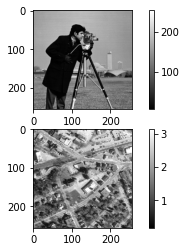

In [54]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time

#reshape size
size_obj=256;

## objectAmplitude와 phase에 이미지 로드, size_obj로 리사이즈 해준다.
objectAmplitude = Image.open('./cameraman.tif')
objectAmplitude = objectAmplitude.resize((size_obj,size_obj))
objectAmplitude=np.array(objectAmplitude)

phase = Image.open('./westconcordorthophoto.png');
phase = phase.resize((size_obj,size_obj))
phase = np.array(phase)
phase = phase/np.max(phase)

object_function = np.multiply(objectAmplitude,np.exp(1j*np.pi*phase))
plt.subplot(2,1,1)
plt.imshow(np.absolute(object_function),cmap='gray')
plt.colorbar()
plt.subplot(2,1,2)
plt.imshow(np.angle(object_function),cmap='gray')
plt.colorbar()
plt.show()




 **Simulate the forward imaging process of Fourier ptychography**
 
 1. setup the parameters for the spatially coherent imaging system
 

In [55]:
#parameter for illumination
waveLength = 0.63e-6;    #사용된 빛의 종류
k0 = 2*np.pi/waveLength; #wavevector

#parameter for camera
spsize = 2.4e-6;        #sampling pixel size of the camera
#parameter for simulation (Ground Truth)
psize = spsize / 8;      #the pixel size of the final reconstructed super-resolution image

#parameter for Imaging System
NA = 0.1;               #NA of 대물렌즈
arraysize = 15;
LEDgap = 4; # 4mm between adjacent LEDs
LEDheight = 100; # distance bewteen the LED matrix and the sample

2. Create the wave vectors for the LED illumiantion 

In [57]:
xlocation = np.zeros((1,arraysize**2));
ylocation = np.zeros((1,arraysize**2));

for i in range (0,arraysize):# from top left to bottom right
    for k in range(0,arraysize):
        xlocation[0,k+arraysize*(i)] = (((1-arraysize)/2)+k)*LEDgap
        ylocation[0,k+arraysize*(i)] = ((arraysize-1)/2-(i))*LEDgap

## Relative Fourier Domain location of LED array
kx_relative = -np.sin(np.arctan(xlocation/LEDheight));  
ky_relative = -np.sin(np.arctan(ylocation/LEDheight)); 


3. Generate the low-pass filtered images

32


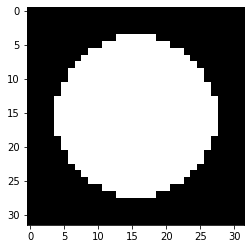

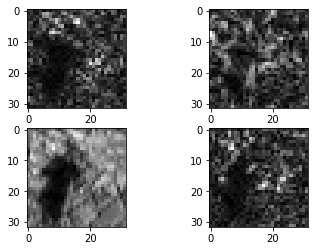

In [58]:
[m,n] = object_function.shape; #image size of high resolution object
m1 = int(m/(spsize/psize))     #image size of the final output
n1 = int(n/(spsize/psize))     

imSeqLowRes = np.zeros((m1, n1, arraysize**2)); #the final low resolution image sequence
kx = k0 * kx_relative;                 
ky = k0 * ky_relative;
dkx = 2*np.pi/(psize*n);
dky = 2*np.pi/(psize*m);
cutoffFrequency = NA * k0;
kmax = np.pi/spsize
kxm=np.zeros((m1,n1))
kym=np.zeros((m1,n1))

##
instx=np.linspace(-kmax,kmax,m1)
insty=np.linspace(-kmax,kmax,n1)
[kxm, kym]= np.meshgrid(instx,insty)
CTF = ((kxm**2+kym**2)<cutoffFrequency**2); #pupil function circ(kmax);
plt.imshow(CTF,cmap='gray')
plt.show()

objectFT = np.fft.fftshift(np.fft.fft2(object_function));

## Low Resolution 묶음 만들기
for tt in range (0,arraysize**2):
    kxc = int((n+1)/2+kx[0,tt]/dkx)
    kyc = int((m+1)/2+ky[0,tt]/dky)
    kxl=int((kxc-(n1-1)/2))
    kxh=int((kxc+(n1-1)/2))
    kyl=int((kyc-(m1-1)/2))
    kyh=int((kyc+(m1-1)/2))
    
    imSeqLowFT = ((m1/m)**2) * objectFT[kyl:kyh+1,kxl:kxh+1]* CTF
    
    imSeqLowRes[:,:,tt] = np.absolute(np.fft.ifft2(np.fft.ifftshift(imSeqLowFT)))
    ## 촬영되는 이미지를 저장하려면
#     plt.imsave('image_'+str(tt)+'.png',imSeqLowRes[:,:,1])


    
## Low Resolution Images
plt.subplot(2,2,1)
plt.imshow(imSeqLowRes[:,:,0],cmap='gray')
plt.subplot(2,2,2)
plt.imshow(imSeqLowRes[:,:,100],cmap='gray')
plt.subplot(2,2,3)
plt.imshow(imSeqLowRes[:,:,110],cmap='gray')
plt.subplot(2,2,4)
plt.imshow(imSeqLowRes[:,:,14],cmap='gray')
plt.show()





**Simulate the recovering process to  high resolution image**

1. Make a sequence


In [59]:
def gseq(arraysize):

  n=(arraysize+1)/2;
  sequence=np.zeros((2,arraysize**2))
  sequence[0,0]=n;
  sequence[1,0]=n;			
  dx=+1;
  dy=-1;
  stepx=+1;
  stepy=-1;
  direction=+1;
  counter=0;
  
  for i in range (1,arraysize**2):
      counter=counter+1;
      if (direction==+1):
          sequence[0,i]=sequence[0,i-1]+dx;
          sequence[1,i]=sequence[1,i-1];
          if (counter==abs(stepx)):
              counter=0;
              direction=direction*-1;
              dx=dx*-1;
              stepx=stepx*-1;
              if stepx>0:
                  stepx=stepx+1;
              else:
                  stepx=stepx-1;

      else:
          sequence[0,i]=sequence[0,i-1];
          sequence[1,i]=sequence[1,i-1]+dy;
          if (counter==abs(stepy)):
              counter=0;
              direction=direction*-1;
              dy=dy*-1;
              stepy=stepy*-1;
              if (stepy>0):
                  stepy=stepy+1;
              else:
                  stepy=stepy-1;

  seq=(sequence[0,:]-1)*arraysize+sequence[1,:]
  return seq


2. Recover high resolution image

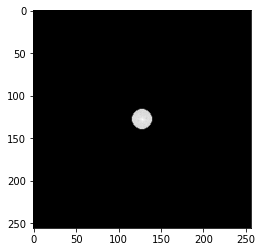

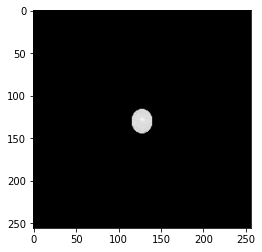

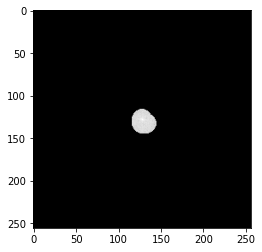

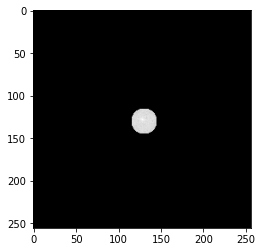

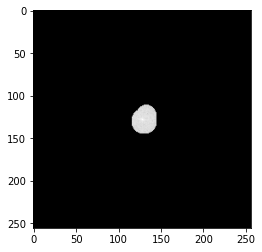

In [60]:


seq=gseq(arraysize)
objectRecover = np.ones((m,n));

objectRecoverFT = np.fft.fftshift(np.fft.fft2(objectRecover));


plt.imshow(CTF,cmap='gray')
plt.show

loop = 5;
for tt in range (0,loop):
    for i3 in range(0,arraysize**2):
        i2=int(seq[i3]-1)
        
        kxc = int((n+1)/2+kx[0,i2]/dkx);
        kyc = int((m+1)/2+ky[0,i2]/dky);
        kxl=int((kxc-(n1-1)/2))
        kxh=int((kxc+(n1-1)/2))
        kyl=int((kyc-(m1-1)/2))
        kyh=int((kyc+(m1-1)/2))
        
        lowResFT = ((m1/m)**2) * objectRecoverFT[kyl:kyh+1,kxl:kxh+1]* CTF
        
        im_lowRes = np.fft.ifft2(np.fft.ifftshift(lowResFT));
        
        im_lowRes = (m/m1)**2 * np.multiply(imSeqLowRes[:,:,i2],np.exp(1j*np.angle(im_lowRes)))
        
        lowResFT=np.fft.fftshift(np.fft.fft2(im_lowRes))*CTF;
        
        objectRecoverFT[kyl:kyh+1,kxl:kxh+1]=np.multiply((1-CTF),objectRecoverFT[kyl:kyh+1,kxl:kxh+1]) + lowResFT;                   
        if (tt == 0) and (i3 == 0 or i3 == 1 or i3 == 2 or i3 == 3 or i3 == 4):
            plt.imshow(np.log(0.00000001+np.absolute(objectRecoverFT)),cmap='gray')
            # plt.imshow(abs(np.fft.ifft2(np.fft.ifftshift(objectRecoverFT[kyl:kyh+1,kxl:kxh+1]*CTF))))
  
            plt.show()






**최종 확인 & 초기 이미지와의 비교**

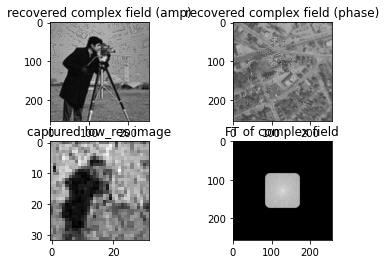

In [65]:
objectRecover=np.fft.ifft2(np.fft.ifftshift(objectRecoverFT));

plt.subplot(221)
plt.imshow(np.absolute(objectRecover),cmap='gray')
plt.title('recovered complex field (amp)')
plt.subplot(222)
plt.imshow(np.angle(objectRecover),cmap='gray');
plt.title('recovered complex field (phase)')
plt.subplot(223)
plt.imshow(imSeqLowRes[:,:,int((arraysize**2+1)/2)],cmap='gray');
plt.title('captured low_res image')
plt.subplot(224)
plt.imshow((np.log(0.01+np.absolute(objectRecoverFT))),cmap='gray');
plt.title('FT of complex field')
plt.show()
